# 血液細胞の検出

ここでは血液細胞の検出タスクに取り組みます。人の血液の顕微鏡画像が与えられたときに、赤血球（Red Blood Cell; RBC）・白血球（White Blood Cell; WBC）・血小板（Platelet）の3種の細胞をそれぞれ**どの位置にあるか**個別に認識します。これによって、画像内にそれらの細胞が何個づつあるか、ということが分かります。

具体的には、Computer visionという研究領域において、**物体検出（object detection）**と呼ばれているタスクに取り組みます。これは、物体の**種類と位置**を画像中から特定するタスクのことを言い、一般的に画像が与えられた際に$n$個のbounding box（物体を囲む矩形）と各bounding boxに対応したクラスを出力することを指します。bounding boxは（矩形の左上のy座標, 矩形の左上のx座標, 矩形の右下のy座標, 矩形の右下のx座標）のようなタプルで定義され、それぞれクラスラベルの属性を持ちます。

今回は物体検出によく用いられるSingle Shot Multibox Detector（通称SSD）というモデルを、血液細胞の検出に用いてみましょう。

## 準備

まず環境構築のため以下のセルを実行してChainer, CuPy, ChainerCV, matplotlibといったPythonパッケージのインストールを済ませます。

In [0]:
!curl https://colab.chainer.org/install | sh -
!pip install chainercv matplotlib

!pip uninstall -y chainer cupy-cuda80
!pip install chainer --pre
!pip install cupy-cuda80 --pre

環境のセットアップが成功したことを以下のセルを実行して確認しましょう。

In [0]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.33+-x86_64-with-Ubuntu-17.10-artful
Chainer: 5.0.0rc1
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0rc1
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2213


## データセットの準備

### データセットダウンロード

今回は[BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset)という血液の顕微鏡画像と、画像それぞれに対してRBC, WBC, Plateletの3つの物体に対するbounding boxのアノテーションが用意された小規模なデータセットを用います。このデータセットはGithubリポジトリで配布されていますので、以下のセルを実行してデータセットをダウンロードしましょう。

In [0]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 770, done.
remote: Total 770 (delta 0), reused 0 (delta 0), pack-reused 770
Receiving objects: 100% (770/770), 7.33 MiB | 44.40 MiB/s, done.
Resolving deltas: 100% (367/367), done.


データセットは以下のうようなファイル構成で配布されています。

```
 BCCD
 |-- Annotations
 |   |
 |   `-- BloodImage_00XYZ.xml (364 items)
 |
 |-- ImageSets
 |   |
 |   `-- Main
 |       |
 |       |-- test.txt
 |       |-- train.txt
 |       |-- trainval.txt
 |       `-- val.txt
 |
 `-- JPEGImages
   |
    `-- BloodImage_00XYZ.jpg (364 items)
 ```

他にもディレクトリがありますが、今回用いるのは上記のファイルだけですので、こちらのみに着目しましょう。

- AnnotationsディレクトリにはVOC formatと呼ばれる形式で細胞画像それぞれに対して**どの位置に何があるか**という、一般的に画像からの物体検出タスクで必要となるラベルの情報が格納されています。
- ImageSetsディレクトリには、学習用データセット・検証用データセット・テスト用データセットのそれぞれに用いる画像のリストが記されたテキストファイルが入っています。これを使ってデータセットの分割を行います。
- JPEGImagesディレクトリには、実際に学習や検証・テストに用いる画像データが入っています。

### データセットオブジェクト作成

ChainerCVにはPascal VOCデータセットを簡単に読み込むための便利なクラスが用意されています。これを継承し、`_get_annotations`メソッドをオーバーライドして今回使用するデータセットに合わせて変更を加えます。変更が必要な行は１行だけです。[こちら](https://github.com/chainer/chainercv/blob/v0.10.0/chainercv/datasets/voc/voc_bbox_dataset.py#L90-L115)から該当するコードをコピーしてきて、以下の変更を行います。

```
- label.append(voc_utils.voc_bbox_label_names.index(name))
+ label.append(bccd_labels.index(name))
```

In [0]:
import os
import xml.etree.ElementTree as ET

import numpy as np

from chainercv.datasets import VOCBboxDataset


bccd_labels = ('rbc', 'wbc', 'platelets')


class BCCDDataset(VOCBboxDataset):

    def _get_annotations(self, i):
        id_ = self.ids[i]
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))
        bbox = []
        label = []
        difficult = []
        for obj in anno.findall('object'):
            # when in not using difficult split, and the object is
            # difficult, skipt it.
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue

            difficult.append(int(obj.find('difficult').text))
            bndbox_anno = obj.find('bndbox')
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(bccd_labels.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool)
        return bbox, label, difficult

これで、今回用いるデータセットクラスを定義することができました。では、これを用いて学習・検証・テスト用のデータセットオブジェクトを作成してみましょう。

In [0]:
train_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'train')
valid_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'val')
test_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'test')

/usr/local/lib/python3.6/dist-packages/chainercv/datasets/voc/voc_bbox_dataset.py:63: UserWarning: please pick split from 'train', 'trainval', 'val'for 2012 dataset. For 2007 dataset, you can pick 'test' in addition to the above mentioned splits.
  'please pick split from \'train\', \'trainval\', \'val\''


ではデータを可視化して確認してみましょう。trainデータセットから一つデータと対応するラベル情報（bounding boxとクラスの組）を取り出し、ChainerCVが用意している可視化用の便利な関数を使って、画像の上にbounding boxおよび対応するクラスラベルを表示してみます。

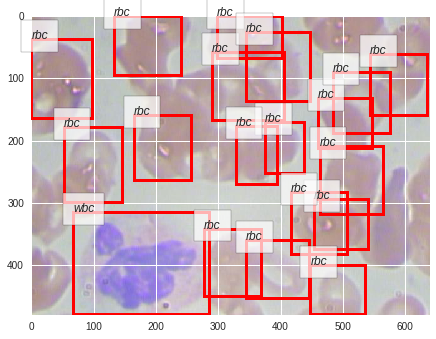

In [0]:
from chainercv.visualizations import vis_bbox

img, bbox, label = train_dataset[0]
vis_bbox(img, bbox, label, label_names=bccd_labels)

## モデルの定義

データの準備が完了したので、今回訓練するモデルの定義を行います。今回は、[Single Shot MultiBox Detector (SSD)](https://arxiv.org/abs/1512.02325)というモデルを使ってみます。基本的な実装はChainerCVが提供してくれているので、学習に必要なロス関数を計算するクラスを用意しましょう。

以下に定義するクラスは、まずSSDモデルのオブジェクトと、ロス計算のためのハイパーパラメータである `alpha` と `k` をコンストラクタで受け取っています。`alpha` は、位置の予測に対する誤差とクラスの予測に対する誤差それぞれの間の重み付けを行う係数です。`k` は hard negative mining のためのパラメータです。学習時、一つの正解bounding boxに対して、モデルは一つの近しい（positiveな）予測と、多くの間違った（negativeな）予測を出力します。この多くの間違った予測をconfidence score（モデルがどの程度確信を持ってその予測を出力しているかを表す値）によってソートした上で、上から positive : negative が 1:k になるように negative サンプルを選択し、ロスの計算に使用します。このバランスを決めているのが `k` というパラメータで、上記論文中では $k = 3$ とされているため、ここでもデフォルトで 3 を使っています。

`forward` メソッドでは、入力画像と正解の位置・ラベルのリストを受け取って、実際にロスの計算を行っています。物体検出は、物体のlocalization（位置の予測）とclassification（種類（＝クラス）の予測）の二つの問題を同時に解きます。

In [0]:
import chainer

from chainercv.links.model.ssd import multibox_loss


class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def forward(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss
    

In [0]:
import copy

import numpy as np

from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation


class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [0]:
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainercv.links import SSD300
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling


batchsize = 32
gpu_id = 0
out = 'results'

model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')
model.nms_thresh = 0.5
model.score_thresh = 0.6
train_chain = MultiboxTrainChain(model)

transformed_train_dataset = TransformDataset(train_dataset, Transform(model.coder, model.insize, model.mean))

train_iter = chainer.iterators.MultiprocessIterator(transformed_train_dataset, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batchsize, repeat=False, shuffle=False)

optimizer = chainer.optimizers.MomentumSGD(lr=0.001)
optimizer.setup(train_chain)
for param in train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (100, 'epoch'), out)
# trainer.extend(
#     extensions.ExponentialShift('lr', 0.1, init=1e-3),
#     trigger=triggers.ManualScheduleTrigger([20, 25], 'epoch'))

trainer.extend(
    DetectionVOCEvaluator(
        valid_iter, model, use_07_metric=False,
        label_names=bccd_labels),
    trigger=(1, 'epoch'))

log_interval = 1, 'epoch'
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map']),
    trigger=log_interval)
# trainer.extend(extensions.ProgressBar(update_interval=10))
trainer.extend(extensions.snapshot(), trigger=(10, 'epoch'))

trainer.run()

From: https://chainercv-models.preferred.jp/ssd_vgg16_imagenet_converted_2017_06_09.npz
To: /root/.chainer/dataset/_dl_cache/b4130ae0aa259c095b50ff95d81c32ee
  %   Total    Recv       Speed  Time left
100   76MiB   76MiB   5147KiB/s    0:00:00epoch       iteration   lr          main/loss   main/loss/loc  main/loss/conf  validation/main/map
1           7           0.001       11.0425     2.92842        8.11407         0.143747             
2           13          0.001       8.89206     2.50786        6.3842          0.0193187            
3           20          0.001       10.1544     2.70715        7.44724         0.0753632            
4           26          0.001       7.89106     2.36177        5.52929         0.000144953          
5           33          0.001       7.91661     2.23753        5.67908         0.199806             
6           39          0.001       7.4341      2.1627         5.2714          0.0259546            
7           45          0.001       6.14611     1.98